In [1]:
import fitter as fitter

from channel_analyser import channel

import numpy as np
import matplotlib.pyplot as plt
plt.style.use("science")

In [13]:
## Channel configuration:

model = "Garching"
modelNo = 82703
dist = 10

channels = {}
channels["eES"] = channel("eES", "NO", "Garching", 82703, 5.0, fitTmin=-0.02, fitTmax=0.02, dist=dist, exp="SuperK")
channels["IBD"] = channel("IBD", "NO", "Garching", 82703, 5.0, fitTmin=-0.02, fitTmax=0.02, dist=dist, exp="SuperK")

scale = 100 / dist**2

for cha in channels.values():
    cha.setScale(scale)
    # set pdf file names:
    cha.setNOPdfFilePath(f"/junofs/users/miaoyu/supernova/simulation/C++/jobs/{model}{modelNo}_PDF_NO_10kpc_{cha.name}_{cha.Ethr:.2f}MeV_SuperK.root")
    cha.setIOPdfFilePath(f"/junofs/users/miaoyu/supernova/simulation/C++/jobs/{model}{modelNo}_PDF_IO_10kpc_{cha.name}_{cha.Ethr:.2f}MeV_SuperK.root")

    cha._load_pdf()



 ========= Load eES 1D PDF ========= 

/junofs/users/miaoyu/supernova/simulation/C++/jobs/Garching82703_PDF_NO_10kpc_eES_0.20MeV_newshortPDF_v2.root
/junofs/users/miaoyu/supernova/simulation/C++/jobs/Garching82703_PDF_IO_10kpc_eES_0.20MeV_newshortPDF_v2.root

 ========= Load IBD 1D PDF ========= 

/junofs/users/miaoyu/supernova/simulation/C++/jobs/Garching82703_PDF_NO_10kpc_IBD_0.20MeV_newshortPDF_v2.root
/junofs/users/miaoyu/supernova/simulation/C++/jobs/Garching82703_PDF_IO_10kpc_IBD_0.20MeV_newshortPDF_v2.root


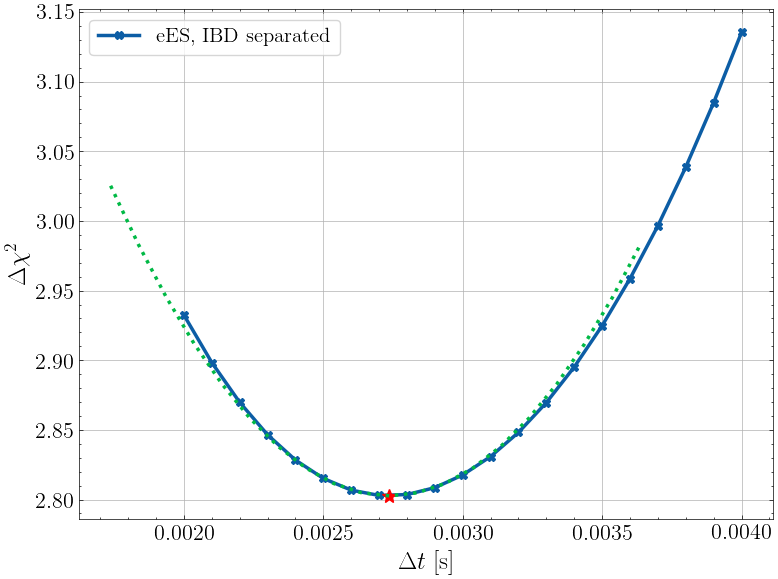

In [17]:
from importlib import reload
reload(fitter)

MO = "IO"
dist = 10
scale = 100 / dist**2
for cha in channels.values():
    cha.setScale(scale)

# coarse scanning
dt_arr = np.arange(-0.01, 0.011, 0.001)
dchi2_arr = fitter.scanning_asimov1D_combined(dt_arr, channels["eES"], channels["IBD"], MO)
Tbest, locMin, _ = fitter.find_locMin(dt_arr, dchi2_arr)
dchi2_arr_sep = fitter.scanning_asimov1D_separate(dt_arr, channels.values(), MO)
Tbest_sep, locMin_sep, _ = fitter.find_locMin(dt_arr, dchi2_arr_sep)
# fine scanning
dt_arr = fitter.generate_fine_dtarr(Tbest)
dchi2_arr = fitter.scanning_asimov1D_combined(dt_arr, channels["eES"], channels["IBD"], MO)
Tbest, locMin, a, b, c = fitter.parabola_fit(dt_arr, dchi2_arr)
dt_arr_sep = fitter.generate_fine_dtarr(Tbest_sep)
dchi2_arr_sep = fitter.scanning_asimov1D_separate(dt_arr_sep, channels.values(), MO)
Tbest_sep, locMin_sep, a_sep, b_sep, c_sep = fitter.parabola_fit(dt_arr_sep, dchi2_arr_sep)

write_chi2 = False
if write_chi2:
    outfile = f"../results/Garching82703_variedDist_SuperK_{MO}_eESIBD_MOSensAsimov_CombSep.csv"
    with open(outfile, "a+") as f:
        f.write(f"{dist}, {Tbest}, {locMin}, {Tbest_sep}, {locMin_sep}")
        f.write("\n")

plot_chi2profile = True
if plot_chi2profile:
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(dt_arr, dchi2_arr, "o-", lw=2.5, label="eES, IBD combined")
    ax.plot(Tbest, locMin, "*", ms=10, color="red")
    x = np.arange(Tbest - 0.001, Tbest + 0.001, 0.0001)
    y = np.polyval([a, b, c], x)
    ax.plot(x, y, ":", lw=2.5)

    ax.plot(dt_arr_sep, dchi2_arr_sep, "X-", lw=2.5, label="eES, IBD separated")
    ax.plot(Tbest_sep, locMin_sep, "*", ms=10, color="red")
    x = np.arange(Tbest_sep - 0.001, Tbest_sep + 0.001, 0.0001)
    y = np.polyval([a_sep, b_sep, c_sep], x)
    ax.plot(x, y, ":", lw=2.5)

    ax.set_xlabel(r"$\Delta t$ [s]", fontsize=18)
    ax.set_ylabel(r"$\Delta\chi^2$", fontsize=18)
    ax.tick_params(axis="both", labelsize=16)
    ax.grid(True)
    ax.legend(prop={"size":15}, frameon=True)
    plt.tight_layout()
    plt.savefig(f"../plots/Garching82703_10kpc_{MO}_HyperK_AsimovChi2Profile.pdf")

In [4]:
## Channel configuration:

model = "Garching"
modelNo = 82703
dist = 10

channels = {}
channels["eES"] = channel("eES", "IO", "Garching", modelNo, 0.20, fitTmin=-0.02, fitTmax=0.02, dist=dist, exp="JUNO")
channels["IBD"] = channel("IBD", "IO", "Garching", modelNo, 0.20, fitTmin=-0.02, fitTmax=0.02, dist=dist, exp="JUNO")
channels["pES"] = channel("pES", "IO", "Garching", modelNo, 0.10, fitTmin=-0.02, fitTmax=0.02, dist=dist, exp="JUNO")

for cha in channels.values():
    # set pdf file names:
    cha.setNOPdfFilePath(f"/junofs/users/miaoyu/supernova/simulation/C++/jobs/{model}{modelNo}_PDF_NO_10kpc_{cha.name}_{cha.Ethr:.2f}MeV_newshortPDF_v2.root")
    cha.setIOPdfFilePath(f"/junofs/users/miaoyu/supernova/simulation/C++/jobs/{model}{modelNo}_PDF_IO_10kpc_{cha.name}_{cha.Ethr:.2f}MeV_newshortPDF_v2.root")

    cha._load_pdf()



 ========= Load eES 1D PDF ========= 

/junofs/users/miaoyu/supernova/simulation/C++/jobs/Garching82703_PDF_NO_10kpc_eES_0.20MeV_newshortPDF_v2.root
/junofs/users/miaoyu/supernova/simulation/C++/jobs/Garching82703_PDF_IO_10kpc_eES_0.20MeV_newshortPDF_v2.root

 ========= Load IBD 1D PDF ========= 

/junofs/users/miaoyu/supernova/simulation/C++/jobs/Garching82703_PDF_NO_10kpc_IBD_0.20MeV_newshortPDF_v2.root
/junofs/users/miaoyu/supernova/simulation/C++/jobs/Garching82703_PDF_IO_10kpc_IBD_0.20MeV_newshortPDF_v2.root

 ========= Load pES 1D PDF ========= 

/junofs/users/miaoyu/supernova/simulation/C++/jobs/Garching82703_PDF_NO_10kpc_pES_0.10MeV_newshortPDF_v2.root
/junofs/users/miaoyu/supernova/simulation/C++/jobs/Garching82703_PDF_IO_10kpc_pES_0.10MeV_newshortPDF_v2.root


In [29]:
from importlib import  reload
reload(fitter)

# coarse scanning
dt_arr = np.arange(-0.01, 0.011, 0.001)

dtpES, dchi2pES, TbestpES, locMinpES, apES, bpES, cpES = fitter.scanning_chain("1D_sep", dt_arr, [channels["pES"]], "IO")
dtIBD, dchi2IBD, TbestIBD, locMinIBD, aIBD, bIBD, cIBD = fitter.scanning_chain("1D_sep", dt_arr, [channels["IBD"]], "IO")
dteESIBD, dchi2eESIBD, TbesteESIBD, locMineESIBD, aeESIBD, beESIBD, ceESIBD = fitter.scanning_chain("1D_sep", dt_arr, [channels["eES"], channels["IBD"]], "IO")
dteESIBDpES, dchi2eESIBDpES, TbesteESIBDpES, locMineESIBDpES, aeESIBDpES, beESIBDpES, ceESIBDpES = fitter.scanning_chain("1D_sep", dt_arr, channels.values(), "IO")


dtpES_r, dchi2pES_r, TbestpES_r, locMinpES_r, apES_r, bpES_r, cpES_r = fitter.scanning_chain("1D_sep", dt_arr, [channels["pES"]], "IO", reverse=True)
dtIBD_r, dchi2IBD_r, TbestIBD_r, locMinIBD_r, aIBD_r, bIBD_r, cIBD_r = fitter.scanning_chain("1D_sep", dt_arr, [channels["IBD"]], "IO", reverse=True)
dteESIBD_r, dchi2eESIBD_r, TbesteESIBD_r, locMineESIBD_r, aeESIBD_r, beESIBD_r, ceESIBD_r = fitter.scanning_chain("1D_sep", dt_arr, [channels["eES"], channels["IBD"]], "IO", reverse=True)
dteESIBDpES_r, dchi2eESIBDpES_r, TbesteESIBDpES_r, locMineESIBDpES_r, aeESIBDpES_r, beESIBDpES_r, ceESIBDpES_r = fitter.scanning_chain("1D_sep", dt_arr, channels.values(), "IO", reverse=True)


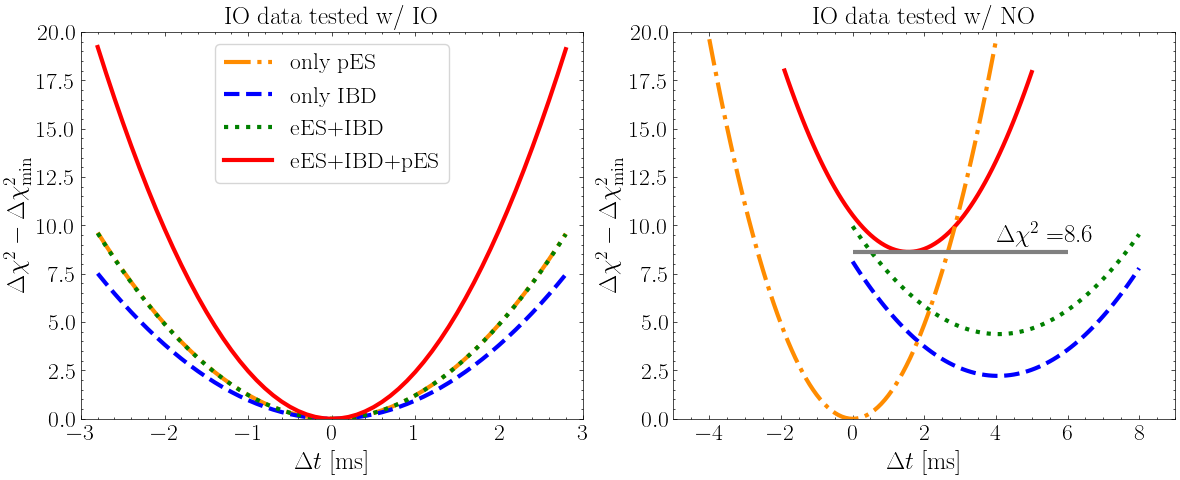

In [51]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
x = np.arange(-0.0028, 0.0029, 0.0001)
y = np.polyval([apES_r, bpES_r, cpES_r], x)
ax[0].plot(x*1000, y, "-.", color="darkorange", lw=3, label="only pES")
x = np.arange(-0.0028, 0.0029, 0.0001)
y = np.polyval([aIBD_r, bIBD_r, cIBD_r], x)
ax[0].plot(x*1000, y, "--", lw=3, color="blue", label="only IBD")
x = np.arange(-0.0028, 0.0029, 0.0001)
y = np.polyval([aeESIBD_r, beESIBD_r, ceESIBD_r], x)
ax[0].plot(x*1000, y, ":", lw=3, color="green", label="eES+IBD")
x = np.arange(-0.0028, 0.0029, 0.0001)
y = np.polyval([aeESIBDpES_r, beESIBDpES_r, ceESIBDpES_r], x)
ax[0].plot(x*1000, y, "-", lw=3, color="red", label="eES+IBD+pES")

ax[0].set_xlabel(r"$\Delta t$ [ms]", fontsize=18)
ax[0].set_ylabel(r"$\Delta\chi^2 - \Delta\chi^2_\mathrm{min}$", fontsize=18)
ax[0].tick_params(axis="both", labelsize=17)
ax[0].legend(prop={"size":17}, frameon=True)
ax[0].set_xlim(-3, 3)
ax[0].set_ylim(0, 20)
ax[0].set_title("IO data tested w/ IO", fontsize=18)


x = np.arange(-0.0019, 0.0051, 0.0001)
y0 = aeESIBDpES * x**2 + beESIBDpES * x + ceESIBDpES
ax[1].plot(x*1000, y0, "-", color="red", lw=3, label="eES+IBD+pES")
x = np.arange(-0.000, 0.0081, 0.0001)
y = aeESIBD * x**2 + beESIBD * x + ceESIBD
ax[1].plot(x*1000, y, ":", color="green", lw=3, label="eES+IBD")
x = np.arange(-0.000, 0.0081, 0.0001)
y = aIBD * x**2 + bIBD * x + cIBD
ax[1].plot(x*1000, y, "--", color="blue", lw=3, label="only IBD")
x = np.arange(-0.004, 0.0041, 0.0001)
y = apES * x**2 + bpES * x + cpES
ax[1].plot(x*1000, y, "-.", color="darkorange", lw=3, label="only pES")
ax[1].set_xlabel(r"$\Delta t$ [ms]", fontsize=18)
ax[1].set_ylabel(r"$\Delta\chi^2 - \Delta\chi^2_\mathrm{min}$", fontsize=18)
ax[1].tick_params(axis="both", labelsize=17)
#ax[1].legend(prop={"size":15}, frameon=True)
ax[1].set_xlim(-5, 9)
ax[1].set_ylim(0, 20)
ax[1].set_title("IO data tested w/ NO", fontsize=18)
ax[1].hlines(np.min(y0), 0, 6, linewidth=3, color="gray")
ax[1].text(4, np.min(y0)+0.5, r"$\Delta\chi^2=$"+f"{np.min(y0):.1f}", fontsize=18)

plt.tight_layout()
plt.savefig("../plots/asimovIO_chi2profile.pdf")